## Import Library

In [1]:
import os
import re
import string
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

pd.set_option('display.max_columns', None)

## Load dataset

In [4]:
import pickle

data_filename = 'GSPP11_data_merge_reduce'

try:
    data_df = pickle.load(open(data_filename + '.pickle', 'rb'))
except (OSError, IOError) as e:
    data_df = pd.read_excel(data_filename + '.xlsx')
    pickle.dump(data_df, open(data_filename + '.pickle', 'wb'))

data_df.head(3)

,Date,Condition,GT Number,GT ACTIVE POWER,AMBIENT PRESSURE SELECTED VALUE,AMBIENT PRESSURE Point,GT INLET SCREEN DIFF. PRESS.,GT INLET AIR DIFF. PRESS.,GT INLET FILTER HOUSE AIR TEMP.,GT INLET FILTER HOUSE AIR HUMIDITY,No.1 GT CHILLED WATER SUPPLY TEMP.,SPRINT WATER FLOW,LP SPRINT TOTAL WATER FLOW,LP SPRINT OPERATION HOUR,VIGV POSITION SELECTED,VBVBEL POSITION SELECTED,VSVSEL POSITION SELECTED,No.1 INLET AIR HEATER LEVEL CV POS. DEMAND,LP COMP. INLET TEMP. (T2) SELECTED,GT INLET TEMP. (T10) SELECTED,HP COMP. INLET TEMP. (T25) SELECTED,HP COMP. DISCH. TEMP. (T3) SELECTED,HP COMP. INLET PRESS. (P25),HP COMP. DISCH. PRESS. (PS3),LP TURBINE INLET TEMP. (T48) SELECTED,DIFFERENACE OF T48MAX AND T48MIN,HP ROTOR SPEED (XN25) SELECTED,LP ROTOR SPEED (XNSD) SELECTED,Fuel Gas Volume Flow,LOWER HEATING VALUE,Fuel Specific Gravity Selected,Compressibility Factor Selected,FUEL GAS SUPPLY PRESS.,FUEL GAS SUPPLY TEMP. SELECTED,HRSG INLET FUEL GAS PRESS.,HRSG INLET GAS DUCT TEMP.,HRSG OUTLET FUEL GAS PRESS.,HRSG OUTLET GAS DUCT TEMP.,LP TURBINE INLET TEMP. (T48)
0,2019-01-01 00:00:00,0,1,24.961611,14.456103,1002.521955,0.579197,-0.876408,24.942641,59.018662,44.426224,0.005570,98132.634463,465.728370,28.269185,13.471984,72.954904,72.223297,40.599394,41.138421,121.961115,530.589712,201.596931,2063.180941,852.376481,24.547630,10089.833398,3629.223758,193.406986,45678.880642,0.594959,0.943591,4.360250,58.322947,0.097487,487.367533,0.041327,96.054738,852.312343
1,2019-01-01 01:00:00,0,1,24.955444,14.457948,1002.252039,0.577017,-0.874152,24.495615,59.141301,44.912449,0.005458,98132.645325,465.729958,28.258613,13.214311,72.702084,69.044871,40.933119,41.474002,122.625872,531.528906,201.898162,2063.575507,852.605385,24.563439,10089.025464,3629.442142,193.345791,45628.921037,0.595003,0.943467,4.360398,58.372839,0.110897,487.701040,0.029931,95.927768,852.541196
2,2019-01-01 02:00:00,0,1,25.000464,14.458973,1001.881803,0.576373,-0.874066,23.527854,60.864038,44.869438,0.005346,98132.656186,465.731547,28.235135,13.006690,72.625770,70.603622,40.795232,41.373230,122.755831,531.591234,202.430963,2065.795654,852.410639,24.377013,10087.886271,3630.881414,192.986560,45592.510796,0.595048,0.943500,4.360448,57.630118,0.099417,487.169261,0.018535,95.852131,852.345701


## Prepare dataset

In [8]:
# Fill all NaN with value = 0
nan_df = data_df[data_df.isnull().any(axis=1)]
data_df.iloc[:, 3:] = data_df.iloc[:, 3:].fillna(0)

In [9]:
# Scaling value of features in range of (0,1)

from sklearn.preprocessing import MinMaxScaler

features = data_df.iloc[:, 3:]
scaler = MinMaxScaler((0, 1)).fit(features)

scaled_df = data_df.copy()
scaled_df.iloc[:, 3:] = scaler.transform(scaled_df.iloc[:, 3:])

scaled_df.head(3)

,Date,Condition,GT Number,GT ACTIVE POWER,AMBIENT PRESSURE SELECTED VALUE,AMBIENT PRESSURE Point,GT INLET SCREEN DIFF. PRESS.,GT INLET AIR DIFF. PRESS.,GT INLET FILTER HOUSE AIR TEMP.,GT INLET FILTER HOUSE AIR HUMIDITY,No.1 GT CHILLED WATER SUPPLY TEMP.,SPRINT WATER FLOW,LP SPRINT TOTAL WATER FLOW,LP SPRINT OPERATION HOUR,VIGV POSITION SELECTED,VBVBEL POSITION SELECTED,VSVSEL POSITION SELECTED,No.1 INLET AIR HEATER LEVEL CV POS. DEMAND,LP COMP. INLET TEMP. (T2) SELECTED,GT INLET TEMP. (T10) SELECTED,HP COMP. INLET TEMP. (T25) SELECTED,HP COMP. DISCH. TEMP. (T3) SELECTED,HP COMP. INLET PRESS. (P25),HP COMP. DISCH. PRESS. (PS3),LP TURBINE INLET TEMP. (T48) SELECTED,DIFFERENACE OF T48MAX AND T48MIN,HP ROTOR SPEED (XN25) SELECTED,LP ROTOR SPEED (XNSD) SELECTED,Fuel Gas Volume Flow,LOWER HEATING VALUE,Fuel Specific Gravity Selected,Compressibility Factor Selected,FUEL GAS SUPPLY PRESS.,FUEL GAS SUPPLY TEMP. SELECTED,HRSG INLET FUEL GAS PRESS.,HRSG INLET GAS DUCT TEMP.,HRSG OUTLET FUEL GAS PRESS.,HRSG OUTLET GAS DUCT TEMP.,LP TURBINE INLET TEMP. (T48)
0,2019-01-01 00:00:00,0,1,0.545878,0.999545,0.878784,0.541357,0.592749,0.662345,0.592396,0.964546,0.001126,0.726127,0.013268,0.286145,0.134753,0.731006,0.875253,0.811912,0.939867,0.967630,0.983477,0.786094,0.680234,0.978184,0.571145,0.951457,0.998861,0.591451,0.968120,0.845497,0.971701,0.970759,0.761956,0.311394,0.940795,0.738891,0.845962,0.978188
1,2019-01-01 01:00:00,0,1,0.545744,0.999672,0.863653,0.539319,0.593797,0.650474,0.593627,0.975103,0.001103,0.726127,0.013268,0.286038,0.132176,0.728473,0.836735,0.818586,0.947534,0.972904,0.985218,0.787268,0.680364,0.978447,0.571168,0.951381,0.998921,0.591264,0.967061,0.845560,0.971574,0.970792,0.762608,0.314392,0.941438,0.721699,0.844844,0.978450
2,2019-01-01 02:00:00,0,1,0.546728,0.999743,0.842899,0.538717,0.593837,0.624776,0.610919,0.974169,0.001081,0.726127,0.013268,0.285800,0.130099,0.727708,0.855625,0.815828,0.945232,0.973935,0.985334,0.789346,0.681096,0.978223,0.570895,0.951273,0.999317,0.590166,0.966290,0.845624,0.971608,0.970803,0.752905,0.311826,0.940412,0.704506,0.844178,0.978226


In [10]:
# Split data
from sklearn.model_selection import train_test_split

norm_df = scaled_df[scaled_df['Condition'] == 0]
train_df, val_df = train_test_split(scaled_df, test_size=0.2, random_state=42)
val_df, norm_test_df = train_test_split(val_df, test_size=0.2, random_state=42)

print('Total samples: {:,d}'.format(len(scaled_df)))
print('Normal samples: {:,d}, Abnormal samples: {:,d}'.format(len(norm_df), len(scaled_df)-len(norm_df)))
print()

print('Normal samples split for train/val/test in ratio of {:,d}/{:,d}/{:,d} samples ({:.1f}/{:.1f}/{:.1f}%)'.format(
    len(train_df), len(val_df), len(norm_test_df), 100*len(train_df)/len(scaled_df), 100*len(val_df)/len(scaled_df), 100*len(norm_test_df)/len(scaled_df)))
print()

abnorm_df = scaled_df[scaled_df['Condition'] == 1]
test_df = norm_test_df.append(abnorm_df)
print('Merging normal test samples with abnormal samples for test, total test samples: {:,d}+{:,d} = {:,d} samples'.format(len(norm_test_df), len(abnorm_df), len(test_df)))

Total samples: 29,232
Normal samples: 23,517, Abnormal samples: 5,715

Normal samples split for train/val/test in ratio of 23,385/4,677/1,170 samples (80.0/16.0/4.0%)

Merging normal test samples with abnormal samples for test, total test samples: 1,170+5,715 = 6,885 samples


In [11]:
train_data = train_df.drop(columns=['Date', 'Condition', 'GT Number']).to_numpy()
val_data = val_df.drop(columns=['Date', 'Condition', 'GT Number']).to_numpy()
test_data = test_df.drop(columns=['Date', 'Condition', 'GT Number']).to_numpy()

batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_data)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_data)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_data)).batch(batch_size)

buffer_size = 32
train_ds = train_ds.prefetch(buffer_size=buffer_size)
val_ds = val_ds.prefetch(buffer_size=buffer_size)
test_ds = test_ds.prefetch(buffer_size=buffer_size)

## Build a model

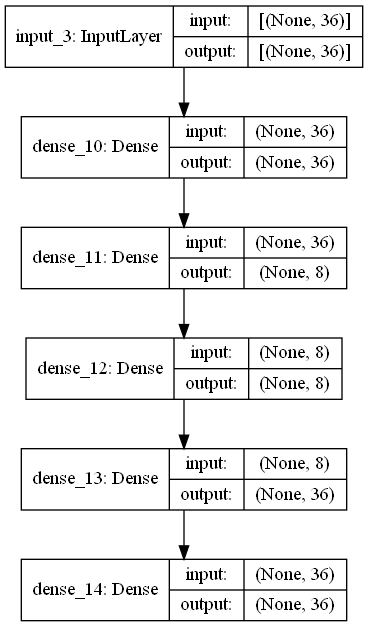

In [15]:
# Model name
model_name = 'model_2'

def make_model(features_number):

    # Encoder
    inputs = layers.Input(shape=(features_number, ))
    x = layers.Dense(36, activation='relu')(inputs)
    # x = layers.Dropout(rate=0.2)(x)
    # x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(8, activation='relu')(x)

    # Decoder
    x = layers.Dense(8, activation='relu')(x)
    # x = layers.Dropout(rate=0.2)(x)
    # x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(36, activation='relu')(x)
    outputs = layers.Dense(features_number)(x)

    return keras.Model(inputs, outputs, name='autoencoder')

model = make_model(features_number=len(features.columns))
keras.utils.plot_model(model, to_file=model_name + '.png', show_shapes=True)
# model.summary()

## Train the model

In [21]:
import datetime

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mse',
    metrics=['accuracy'],
)

# Tensorboard
tb = keras.callbacks.TensorBoard(
    log_dir='logs/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
)

# Checkpoint
cp = keras.callbacks.ModelCheckpoint(
    filepath=model_name + '/' + model_name + '-{epoch:05d}.h5',
    verbose=0,
    save_weights_only=True,
    save_freq=7310,
)
try:
    saved_model_name = 'model_2-02000'
    model.load_weights(model_name + '/' + saved_model_name + '.h5')
    initial_epoch = int(saved_model_name.split('-')[1])
except (OSError, IOError) as e:
    initial_epoch = 0

model.fit(train_ds, epochs=2000, initial_epoch=initial_epoch, validation_data=val_ds, verbose=1, callbacks=[tb, cp])

 loss: 2.9193e-04 - accuracy: 0.6741 - val_loss: 3.0459e-04 - val_accuracy: 0.7030
Epoch 1874/10000
731/731 [==============================] - 1s 2ms/step - loss: 2.9348e-04 - accuracy: 0.6710 - val_loss: 3.2406e-04 - val_accuracy: 0.7030
Epoch 1875/10000
731/731 [==============================] - 1s 2ms/step - loss: 2.9447e-04 - accuracy: 0.6688 - val_loss: 3.0509e-04 - val_accuracy: 0.6930
Epoch 1876/10000
731/731 [==============================] - 1s 2ms/step - loss: 2.9241e-04 - accuracy: 0.6717 - val_loss: 3.0649e-04 - val_accuracy: 0.6923
Epoch 1877/10000
731/731 [==============================] - 1s 2ms/step - loss: 2.9249e-04 - accuracy: 0.6735 - val_loss: 3.0282e-04 - val_accuracy: 0.6789
Epoch 1878/10000
731/731 [==============================] - 1s 2ms/step - loss: 2.9342e-04 - accuracy: 0.6725 - val_loss: 3.0834e-04 - val_accuracy: 0.7022
Epoch 1879/10000
731/731 [==============================] - 1s 2ms/step - loss: 2.9229e-04 - accuracy: 0.6729 - val_loss: 3.0203e-04 - va

KeyboardInterrupt: 

In [22]:
for ds in [train_ds, val_ds, test_ds]:
    print(model.evaluate(ds)[0])

731/731 [==============================] - 1s 1ms/step - loss: 2.8046e-04 - accuracy: 0.7080
0.0002804623800329864
147/147 [==============================] - 0s 1ms/step - loss: 3.1698e-04 - accuracy: 0.7086
0.0003169757255818695
216/216 [==============================] - 0s 1ms/step - loss: 2.8953e-04 - accuracy: 0.7038
0.0002895319485105574


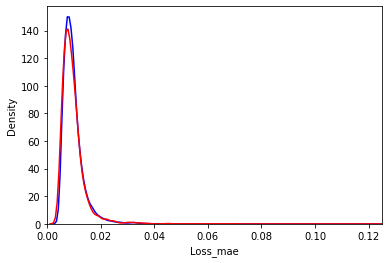

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Normal data
X = norm_df.drop(columns=['Date', 'Condition', 'GT Number'])
Y = pd.DataFrame(model.predict(X.to_numpy()), index=X.index, columns=X.columns)

norm_scored = pd.DataFrame(index=X.index)
norm_scored['Loss_mae'] = np.mean(np.abs(Y-X), axis=1)
norm_scored

# Abnormal data
X = abnorm_df.drop(columns=['Date', 'Condition', 'GT Number'])
Y = pd.DataFrame(model.predict(X.to_numpy()), index=X.index, columns=X.columns)

abnorm_scored = pd.DataFrame(index=X.index)
abnorm_scored['Loss_mae'] = np.mean(np.abs(Y-X), axis=1)

# Plot
plt.figure()
plt.xlim([0.0, 0.125])
sns.distplot(norm_scored['Loss_mae'], bins=30, kde=True, color='blue', hist_kws=dict(edgecolor="k", linewidth=1), hist=False)
sns.distplot(abnorm_scored['Loss_mae'], bins=30, kde=True, color='red', hist_kws=dict(edgecolor="k", linewidth=1), hist=False)
plt.show()